Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/Colab Work/CNN Assignment/CNN_assignment.zip" > /dev/null

### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LayerNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
#Setting train & test paths
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
#Setting required variables
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
#Setting train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               validation_split = 0.2,
                                                               subset = 'training',
                                                               seed = 123,
                                                               image_size = (img_height, img_width),
                                                               batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
#Setting validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             validation_split = 0.2,
                                                             subset = 'validation',
                                                             seed = 123,
                                                             image_size = (img_height, img_width),                                                              
                                                             batch_size = batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
#Setting test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [12]:
#Retrieving class names
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

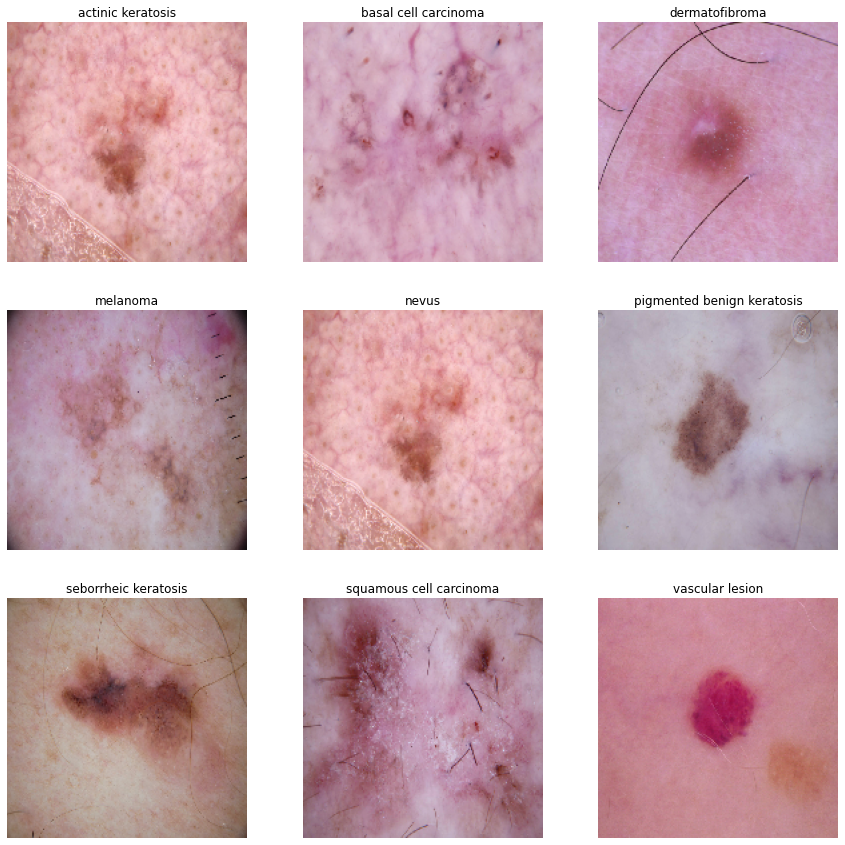

In [13]:
import matplotlib.pyplot as plt
#Dictionary to store the path of image as per the class
files_path_dict = {}
for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = (180, 180, 3))
]

In [16]:
#Building first model
input_shape = (180, 180, 3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))
model.add(layers.Conv2D(16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(layers.MaxPool2D(pool_size = (2, 2)))
model.add(layers.Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
#Compiling model
optimizer = "adam"
model.compile(optimizer = optimizer,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [18]:
#Checking model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

### Train the model

In [19]:
#Training model
epochs = 20
history = model.fit(train_ds,
                    batch_size = batch_size,
                    validation_data = val_ds,
                    epochs=epochs)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 26s 122ms/step - loss: 2.0477 - accuracy: 0.2210 - val_loss: 1.9450 - val_accuracy: 0.2931
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.9019 - accuracy: 0.2829 - val_loss: 1.8571 - val_accuracy: 0.3087
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6708 - accuracy: 0.3901 - val_loss: 1.5727 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4742 - accuracy: 0.4844 - val_loss: 1.4511 - val_accuracy: 0.5056
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3199 - accuracy: 0.5419 - val_loss: 1.3767 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2488 - accuracy: 0.5608 - val_loss: 1.4202 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1383 - accuracy: 0.5865 - val_loss: 1.3553 - val_accuracy: 0.5369
Epoch 8/20
56/56 [====

In [20]:
def print_model_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epochs)
  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

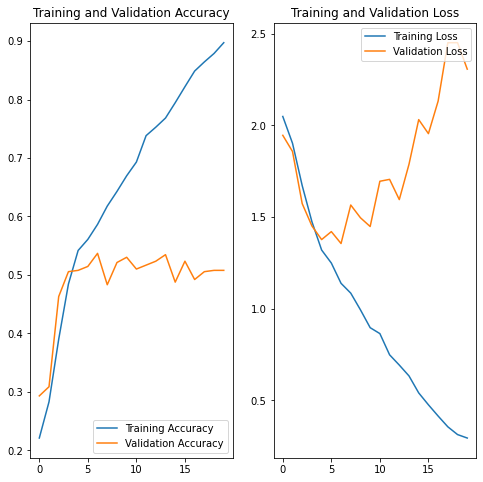

In [21]:
#Printing Accuracy's
print_model_history(history)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

### - Cleary overfits, as there is huge difference in Accuracy & Validation Accuracy, thus we need to handle model overfitting by trying out various combinations.

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
loss, accuracy = model.evaluate(train_ds, verbose = 1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose = 1)
print("Accuracy: ", accuracy)
print("Validation Accuracy: ", accuracy_v)
print("Loss: ", loss)
print("Validation Loss: ", loss_v)

#Thus we can clearly see that model overfit and we need to chose right data augmentation strategy  

14/14 [==============================] - 0s 10ms/step - loss: 2.3057 - accuracy: 0.5078
Accuracy:  0.91796875
Validation Accuracy:  0.5078299641609192
Loss:  0.2232784926891327
Validation Loss:  2.305710554122925


In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1)])

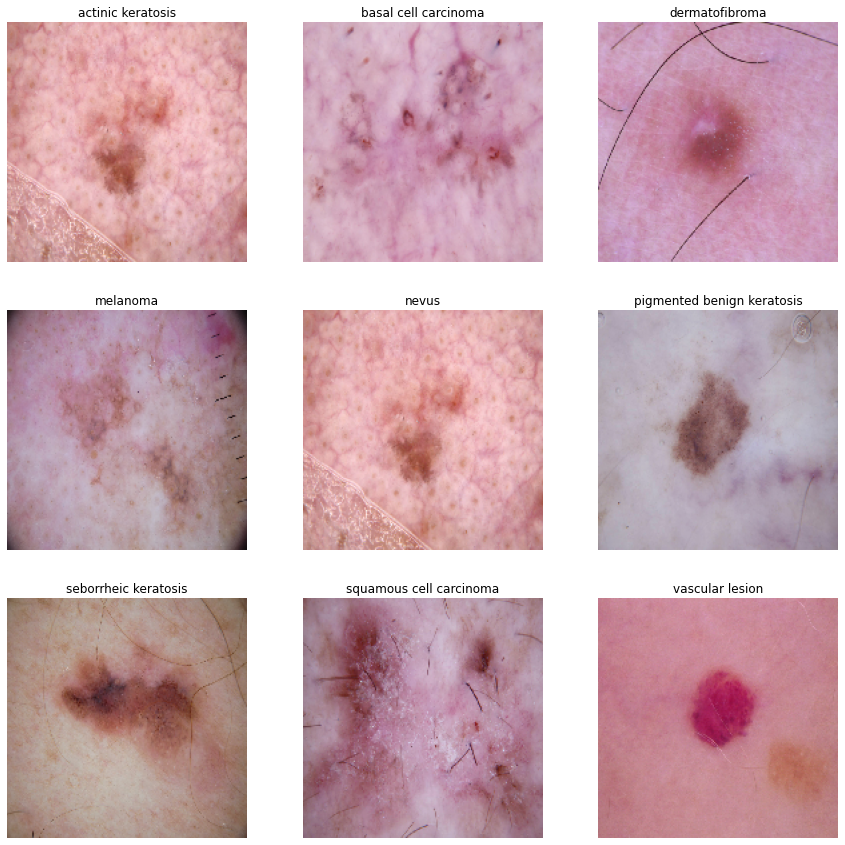

In [24]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
#Dictionary to store the path of image as per the class
files_path_dict = {}
for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train) + '/' + c + '/' + x, os.listdir(str(data_dir_train) + '/' + c)))
    
#Visualize image 
plt.figure(figsize = (15, 15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(load_img(path_list[0],target_size = (180, 180)))
    plt.title(c)
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [29]:
#Building Second Model
img_size = 180
# Build the sequential layers same as before with an extra data augmentation layer
model_augm1 = Sequential([  
  layers.experimental.preprocessing.Resizing(img_size, img_size),# resizing the layer
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [30]:
#Compiling Model
model_augm1.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'],)

### Training the model

In [31]:
epochs = 20
history_augm1 = model_augm1.fit(train_ds,
                                batch_size = batch_size,
                                validation_data = val_ds,
                                epochs = epochs)

Epoch 1/20
56/56 [==============================] - 6s 70ms/step - loss: 30.5620 - accuracy: 0.3030 - val_loss: 1.7489 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 2s 44ms/step - loss: 1.6497 - accuracy: 0.4085 - val_loss: 1.6300 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6362 - accuracy: 0.4046 - val_loss: 1.6695 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6572 - accuracy: 0.3990 - val_loss: 1.7304 - val_accuracy: 0.3848
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6311 - accuracy: 0.3968 - val_loss: 1.7864 - val_accuracy: 0.3714
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6265 - accuracy: 0.4113 - val_loss: 1.6383 - val_accuracy: 0.4385
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5705 - accuracy: 0.4180 - val_loss: 1.6252 - val_accuracy: 0.4027
Epoch 8/20
5

In [32]:
#Checking model summary
model_augm1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Visualizing the results

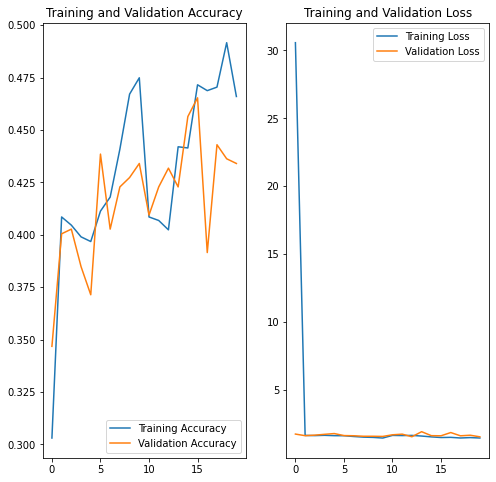

In [33]:
#Printing accuracies
print_model_history(history_augm1)

In [34]:
loss, accuracy = model_augm1.evaluate(train_ds, verbose = 1,)
loss_v, accuracy_v = model_augm1.evaluate(val_ds, verbose = 1)
print("Accuracy: ", accuracy)
print("Validation Accuracy: ", accuracy_v)
print("Loss: ", loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 11ms/step - loss: 1.5466 - accuracy: 0.4340
Accuracy:  0.4972098171710968
Validation Accuracy:  0.4340044856071472
Loss:  1.3730067014694214
Validation Loss 1.5466080904006958


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


### - Model predictions aren't upto the mark, seems to be underfitting. But yes this time Accuracy & Validation Accuracy are close enough.


#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

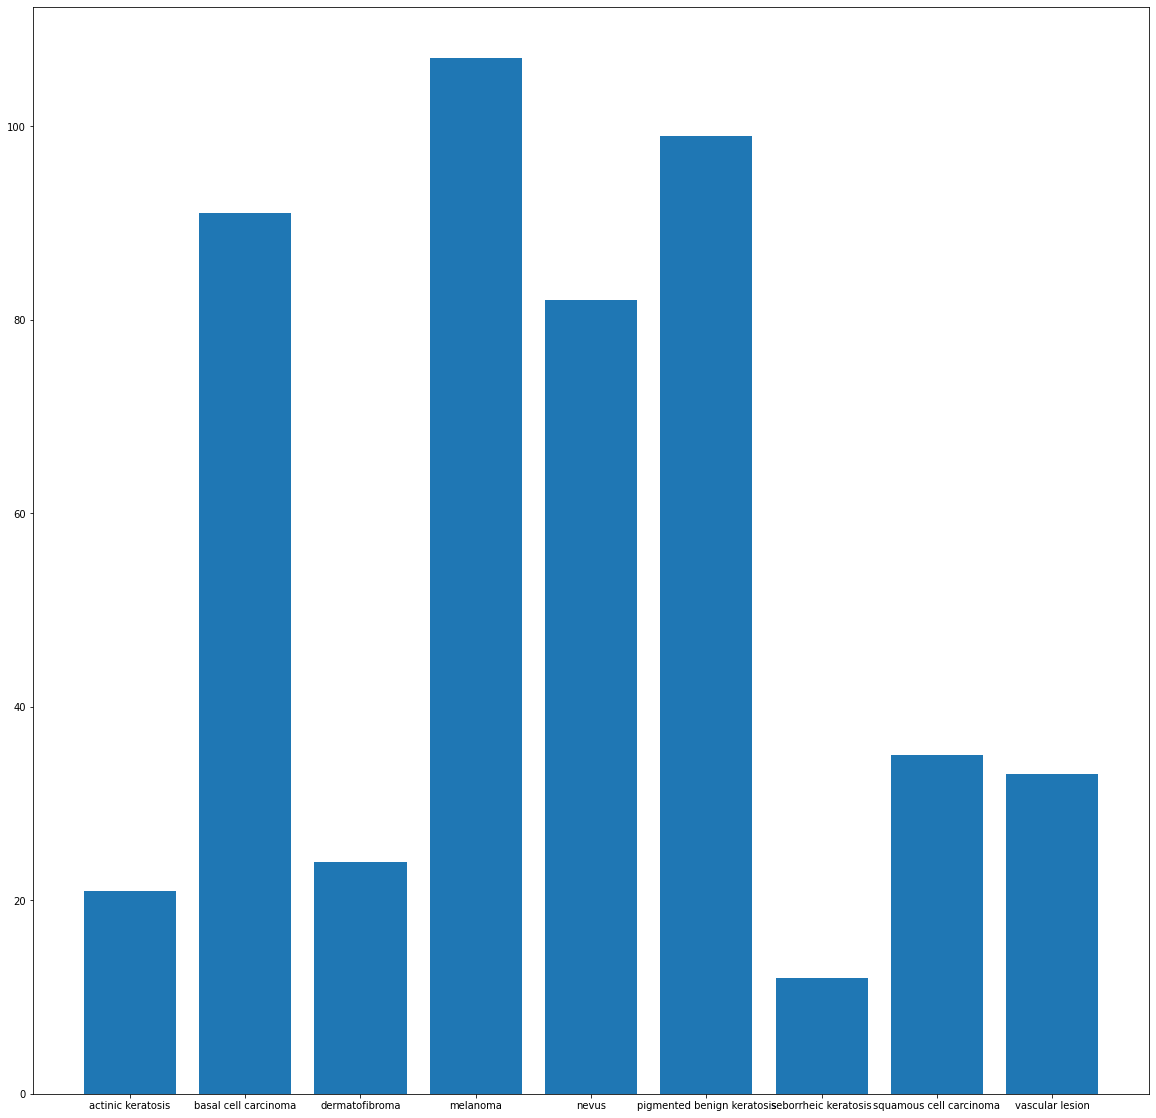

In [35]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize = (10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align = 'center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

In [36]:
#Going through all training dataset batches
class_distr={}

for image_batch, labels_batch in train_ds:
  # prepare the count of images in each class
    for i in range(image_batch.shape[0]):
      if class_names[labels_batch[i]] in class_distr:
        class_distr[class_names[labels_batch[i]]]+=1
      else:
        class_distr[class_names[labels_batch[i]]]=1
# Display the distribution
class_distr

{'nevus': 277,
 'actinic keratosis': 92,
 'melanoma': 352,
 'pigmented benign keratosis': 370,
 'basal cell carcinoma': 309,
 'squamous cell carcinoma': 142,
 'dermatofibroma': 77,
 'vascular lesion': 115,
 'seborrheic keratosis': 58}

In [37]:
#Preparing the class distribution Dataframe to visualize sample numbers
df_sample_distr = pd.DataFrame({"Class Name":class_distr.keys(), "Samples":class_distr.values()})
df_sample_distr.sort_values('Samples',ascending=False)

,Class Name,Samples
3,pigmented benign keratosis,370
2,melanoma,352
4,basal cell carcinoma,309
0,nevus,277
5,squamous cell carcinoma,142
7,vascular lesion,115
1,actinic keratosis,92
6,dermatofibroma,77
8,seborrheic keratosis,58


#### **Todo:** Write your findings here: 
#### Which class has the least number of samples?
Ans: Seborrheic Keratosis	- 58, Dermatofibroma - 77 & Actinic Keratosis - 92	
#### Which classes dominate the data in terms proportionate number of samples?
Ans: Pigmented benign keratosis - 370



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
path_to_training_dataset= "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A35BC81C0>: 100%|██████████| 500/500 [00:16<00:00, 30.99 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A20559D00>: 100%|██████████| 500/500 [00:17<00:00, 28.71 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F09CC435940>: 100%|██████████| 500/500 [00:17<00:00, 28.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7F09B850C760>: 100%|██████████| 500/500 [01:30<00:00,  5.55 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x674 at 0x7F0A9D6AD160>: 100%|██████████| 500/500 [01:26<00:00,  5.80 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F0A20467070>: 100%|██████████| 500/500 [00:15<00:00, 31.37 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F09CC111220>: 100%|██████████| 500/500 [00:38<00:00, 13.03 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F0A200864F0>: 100%|██████████| 500/500 [00:16<00:00, 30.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F09CC154A30>: 100%|██████████| 500/500 [00:16<00:00, 29.73 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [41]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025811.jpg_f6a39b3b-0776-44c4-976a-88aa3004d5bf.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0024923.jpg_7a8dbca3-bac5-428c-ac1d-8b1f9d95159e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031421.jpg_af3c7fd8-9961-4006-8658-a0b45195ae8b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030341.jpg_f9e67e6f-77b9-417e-9be1-6e0f71424f5e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030953.jpg_5421edde-9d76-415b-aa67-d4889d90b0fa.jpg',
 'Skin cancer ISIC The Interna

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [43]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [45]:
new_df['Label'].value_counts()

squamous cell carcinoma       500
nevus                         500
basal cell carcinoma          500
melanoma                      500
vascular lesion               500
actinic keratosis             500
dermatofibroma                500
seborrheic keratosis          500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [46]:
batch_size = 32
img_height = 180
img_width = 180


#### **Todo:** Create a training dataset

In [47]:
#Setting path
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

#Setting train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                              seed=123,
                                                              validation_split = 0.2,
                                                              subset = 'training',
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [48]:
#Setting validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                            seed=123,
                                                            validation_split = 0.2,
                                                            subset = 'validation',
                                                            image_size=(img_height, img_width),
                                                            batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [49]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Building thrid model
model_dp = Sequential()
model_dp.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))

model_dp.add(layers.Normalization(axis = 1, mean = None, variance = None))
model_dp.add(layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = input_shape))
model_dp.add(layers.MaxPool2D())
model_dp.add(layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))
model_dp.add(layers.MaxPool2D())
model_dp.add(layers.Dropout(0.25))
model_dp.add(layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape))
model_dp.add(layers.MaxPool2D())
model_dp.add(layers.Dropout(0.25))
model_dp.add(layers.Flatten())
model_dp.add(layers.Dense(256, activation='relu'))
model_dp.add(layers.Dense(num_classes, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [50]:
#Compiling model
optimizer = "adam"
model_dp.compile(optimizer = optimizer,
                loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [51]:
#Checking model summary
model_dp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 normalization (Normalizatio  (None, 180, 180, 3)      361       
 n)                                                              
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 43, 43, 64)      

#### **Todo:**  Train your model


In [61]:
epochs = 30
batch_size = 20
history_dp = model_dp.fit(train_ds,
                          epochs = epochs, 
                          verbose = 1, 
                          validation_data=val_ds )

Epoch 1/30
169/169 [==============================] - 7s 42ms/step - loss: 1.6308 - accuracy: 0.4160 - val_loss: 1.2853 - val_accuracy: 0.5449
Epoch 2/30
169/169 [==============================] - 7s 41ms/step - loss: 0.8839 - accuracy: 0.6905 - val_loss: 0.8872 - val_accuracy: 0.7342
Epoch 3/30
169/169 [==============================] - 7s 41ms/step - loss: 0.3930 - accuracy: 0.8652 - val_loss: 0.8216 - val_accuracy: 0.7936
Epoch 4/30
169/169 [==============================] - 7s 41ms/step - loss: 0.2578 - accuracy: 0.9134 - val_loss: 0.9725 - val_accuracy: 0.7906
Epoch 5/30
169/169 [==============================] - 7s 41ms/step - loss: 0.2257 - accuracy: 0.9223 - val_loss: 1.0171 - val_accuracy: 0.8107
Epoch 6/30
169/169 [==============================] - 7s 41ms/step - loss: 0.1662 - accuracy: 0.9399 - val_loss: 0.8733 - val_accuracy: 0.8322
Epoch 7/30
169/169 [==============================] - 7s 41ms/step - loss: 0.1499 - accuracy: 0.9420 - val_loss: 0.9404 - val_accuracy: 0.8099

#### **Todo:**  Visualize the model results

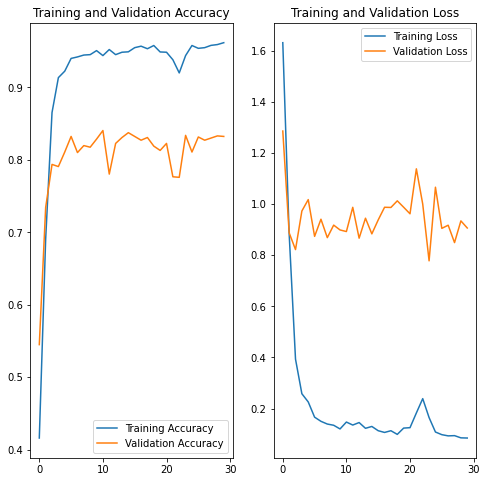

In [62]:
#Printing accuracies
print_model_history(history_dp)

In [63]:
loss, accuracy = model_dp.evaluate(train_ds, verbose = 1,)
loss_v, accuracy_v = model_dp.evaluate(val_ds, verbose = 1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ", accuracy_v)
print("Loss: ", loss)
print("Validation Loss: ", loss_v)

43/43 [==============================] - 1s 16ms/step - loss: 0.9061 - accuracy: 0.8322
Accuracy:  0.968100905418396
Validation Accuracy:  0.8322197198867798
Loss:  0.06929800659418106
Validation Loss:  0.9060571789741516


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

### Yes, class rebalacing works very well, results improvment and thus produces Accuracy ~ 97% and Validation Accuracy ~ 83% 



In [55]:
data_dir_test="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                              seed=123,
                                                              validation_split = 0.2,
                                                              subset = 'training',
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 95 files for training.


In [56]:
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                                  seed=123,
                                                                  validation_split = 0.2,
                                                                  subset = 'validation',
                                                                  image_size=(img_height, img_width),
                                                                  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [57]:
batch_size = 20
history_dp_test = model_dp.fit(test_ds,
                               epochs = epochs, 
                               verbose = 1, 
                               validation_data=val_test_ds )

Epoch 1/30
5/5 [==============================] - 4s 337ms/step - loss: 6.0982 - accuracy: 0.3579 - val_loss: 3.8169 - val_accuracy: 0.3043
Epoch 2/30
5/5 [==============================] - 3s 261ms/step - loss: 2.7705 - accuracy: 0.2947 - val_loss: 2.6449 - val_accuracy: 0.2174
Epoch 3/30
5/5 [==============================] - 3s 265ms/step - loss: 1.6507 - accuracy: 0.3789 - val_loss: 2.1512 - val_accuracy: 0.2174
Epoch 4/30
5/5 [==============================] - 3s 266ms/step - loss: 1.5719 - accuracy: 0.4526 - val_loss: 2.0126 - val_accuracy: 0.3043
Epoch 5/30
5/5 [==============================] - 3s 265ms/step - loss: 1.3517 - accuracy: 0.5474 - val_loss: 2.2394 - val_accuracy: 0.3043
Epoch 6/30
5/5 [==============================] - 3s 263ms/step - loss: 1.1250 - accuracy: 0.5789 - val_loss: 2.2583 - val_accuracy: 0.2609
Epoch 7/30
5/5 [==============================] - 3s 261ms/step - loss: 0.8522 - accuracy: 0.7158 - val_loss: 2.3620 - val_accuracy: 0.3043
Epoch 8/30
5/5 [====

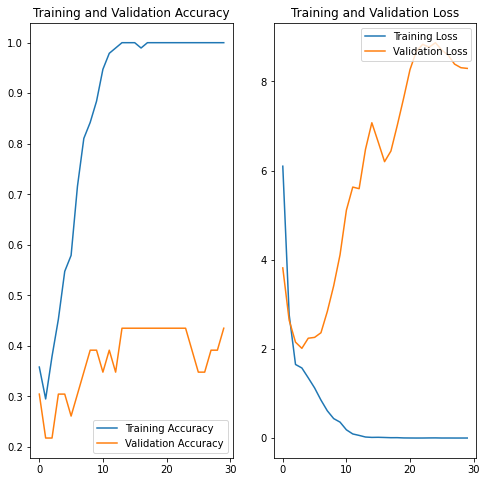

In [58]:
#Printing accuracies
print_model_history(history_dp_test)

In [59]:
loss, accuracy = model_dp.evaluate(test_ds, verbose = 1,)
loss_v, accuracy_v = model_dp.evaluate(val_test_ds, verbose = 1)
print("Accuracy: ", accuracy)
print("Validation Accuracy: ", accuracy_v)
print("Loss: ", loss)
print("Validation Loss: ", loss_v)

2/2 [==============================] - 1s 11ms/step - loss: 8.2924 - accuracy: 0.4348
Accuracy:  1.0
Validation Accuracy:  0.43478259444236755
Loss:  0.00047226325841620564
Validation Loss:  8.292407035827637


### Model predicting for single image 

1/1 [==============================] - 0s 209ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


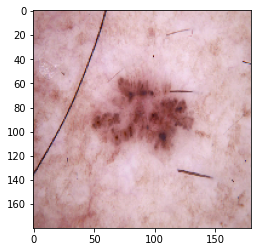

In [60]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180, 180, 3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model_dp.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class: "+ class_names[1] +'\n'+ "Predictive Class: "+ pred_class )

### Correctly identifying the image.